In [ ]:
BiocManager::install("maftools")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.3 (2023-03-15)

Installing package(s) 'maftools'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'arrow', 'collections', 'curl', 'data.table', 'diffobj', 'doBy',
  'future', 'generics', 'gh', 'globals', 'haven', 'httpuv', 'maps', 'miniUI',
  'modeltools', 'nloptr', 'officer', 'openssl', 'parallelly', 'pbkrtest',
  'pkgbuild', 'pkgdown', 'prodlim', 'promises', 'R.cache', 'R.oo',
  'RcppArmadillo', 'recipes', 'reformulas', 'RSQLite', 'sparsevctrs',
  'systemfonts', 'textshaping', 'tinytex', 'utf8', 'writexl', 'zip'



In [1]:
library(maftools)
library(ComplexHeatmap)
library(dplyr)
library(tidyr)
library(tibble)

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [74]:
setwd("/ai/data/wuqiao/clinical_sample/WES/RAW_VCF/MT_analysis_2025.5.14_adjust_annotation/paired code and results_adjusted")

In [75]:
tumor_mutation=read.table("data/95 tumor exon mutation maf.csv",sep=",",quote = "\"",header=T)
clinical_sample=read.table("data/190 samples exon gene mutation paired sample information1.csv",sep=",",quote = "\"",header=T)


In [76]:
tumor_clinical=merge(tumor_mutation,clinical_sample[,-c(1,3)],by.x="Tumor_Sample_Barcode",by.y="Sample")

In [77]:
print(head(tumor_clinical))

  Tumor_Sample_Barcode Hugo_Symbol Chromosome Start_Position End_Position
1            KY-131729         ND6       chrM          14668        14668
2            KY-131729         ND6       chrM          14668        14668
3            KY-131733         ND5       chrM          12923        12923
4            KY-131735         ND2       chrM           5453         5453
5            KY-131735         ND3       chrM          10400        10400
6            KY-131735         ND3       chrM          10400        10400
  Variant_Classification                Variant_Type Reference_Allele
1      nonsynonymous SNV Substitution (Transversion)                C
2         synonymous SNV Substitution (Transversion)                C
3               stopgain   Substitution (Transition)                G
4               stopgain   Substitution (Transition)                A
5      nonsynonymous SNV                   Insertion                C
6   frameshift insertion                   Insertion          

In [15]:
print(dim(tumor_clinical))

[1] 209  16


In [78]:
tumor_clinical$Variant_Classification <- recode(tumor_clinical$Variant_Classification,
  "nonsynonymous SNV" = "Missense_Mutation",
  "synonymous SNV" = "Silent",
  "stopgain" = "Nonsense_Mutation",
  "frameshift deletion" = "Frame_Shift_Del",
  "frameshift insertion" = "Frame_Shift_Ins",
  "nonframeshift deletion" = "In_Frame_Del",
  "nonframeshift insertion" = "In_Frame_Ins"
)

In [79]:
tumor_clinical$Variant_Type <- recode(tumor_clinical$Variant_Type,
  "Substitution (Transition)" = "SNP",
  "Substitution (Transversion)" = "SNP",
  "Insertion" = "INS",
  "Deletion" = "DEL"
)

In [80]:
print(head(tumor_clinical))

  Tumor_Sample_Barcode Hugo_Symbol Chromosome Start_Position End_Position
1            KY-131729         ND6       chrM          14668        14668
2            KY-131729         ND6       chrM          14668        14668
3            KY-131733         ND5       chrM          12923        12923
4            KY-131735         ND2       chrM           5453         5453
5            KY-131735         ND3       chrM          10400        10400
6            KY-131735         ND3       chrM          10400        10400
  Variant_Classification Variant_Type Reference_Allele Tumor_Seq_Allele1
1      Missense_Mutation          SNP                C                 A
2                 Silent          SNP                C                 A
3      Nonsense_Mutation          SNP                G                 A
4      Nonsense_Mutation          SNP                A                 G
5      Missense_Mutation          INS                C             CGGTT
6        Frame_Shift_Ins          INS       

In [81]:
write.table(tumor_clinical,"data/95 tumor samples exon gene mutation sorted maftools_clinical.csv",sep=",",quote=F,row.names=F)

In [82]:
table(tumor_clinical$Variant_Classification)


  Frame_Shift_Del   Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
                9                26                 4                 1 
Missense_Mutation Nonsense_Mutation            Silent 
               68                23                78 

In [83]:
CLI.DF <- tumor_clinical %>%
  select('Tumor_Sample_Barcode', "gender","age","T.stage","N.stage","BRAF.V600E") %>%
  mutate(
    age = case_when(
      age < 55 ~ "<55",
      age >= 55  ~ ">=55")
  )

In [84]:
laml <- read.maf(maf = tumor_clinical,clinicalData = CLI.DF,vc_nonSyn = NULL)

-Validating
--Removed 18 duplicated variants
-Silent variants: 71 
-Summarizing
-Processing clinical data
-Finished in 0.081s elapsed (0.216s cpu) 


In [85]:
print(unique(laml@data$Variant_Classification))

[1] Missense_Mutation Nonsense_Mutation Frame_Shift_Del   Frame_Shift_Ins  
[5] In_Frame_Del      In_Frame_Ins     
6 Levels: Frame_Shift_Del Frame_Shift_Ins In_Frame_Del ... Nonsense_Mutation


Warning message in titv(maf = maf, useSyn = TRUE, plot = FALSE):
“Non standard Ti/Tv class: 152TRUE”


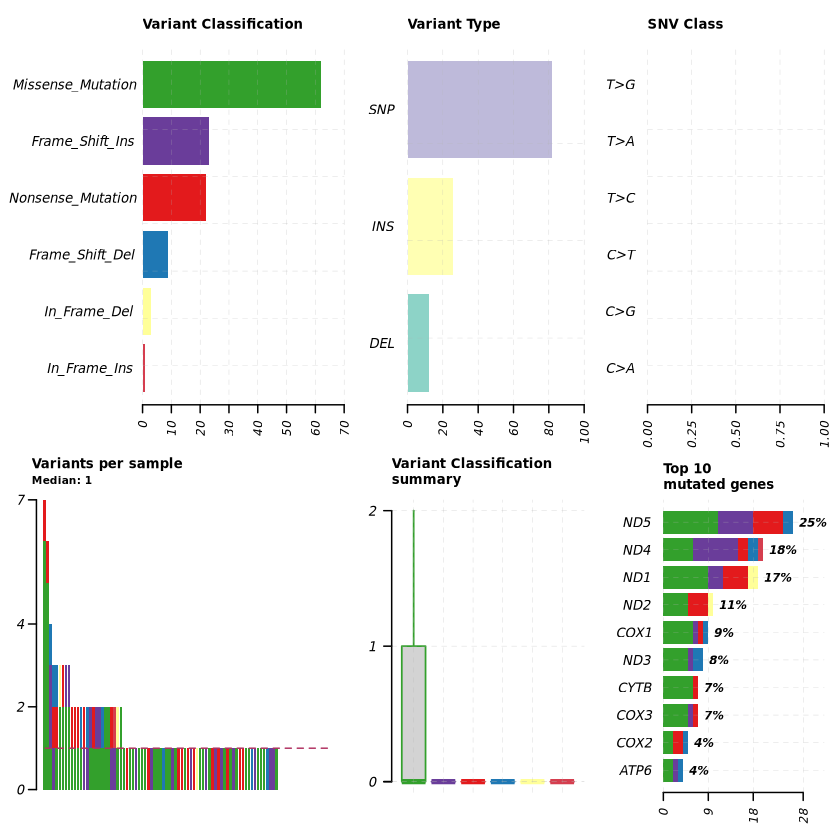

In [86]:
# 绘制突变概览图
plotmafSummary(maf = laml,
               rmOutlier = TRUE,
               addStat = 'median',
               dashboard = TRUE,
               titvRaw = FALSE)

In [87]:
vc_cols <- c(
  "Missense_Mutation" ="#F39B7F",
  "Nonsense_Mutation" = "#8491B4",
  "Frame_Shift_Ins" = "#4DBBD5",
  "Frame_Shift_Del" = "#E64B35",
  "In_Frame_Ins" = "#3C5488",
  "In_Frame_Del" = "#00A087",
  "Silent_shown" = "#91D1C2",
  "Multi_Hit"="#F603E2F9"
)


In [88]:
library(ComplexHeatmap)
# 定义临床特征的颜色
annotationColor = list(
gender = c("Male" = "#A4CEE4", "Female" = "#DDA47B"),
age = c("<55" = "#496fb0", ">=55" = "#9F4E59"),
T.stage = c("T1" = "#cfa5b3", "T2" = "#8BBEBF", "T3" = "#aba94d", "T4" = "#F08650"),
N.stage = c("N0" = "#99D9EA", "N1" = "#7092BE"),
BRAF.V600E = c("0" = "#8AADBE", "1" = "#dcc7d0"))



In [95]:
pdf("plots/oncoplot_top20_tumor_clinical.pdf", width = 13, height =9)
# 绘制 Oncoplot（top20突变基因）
options(ComplexHeatmap.heatmap_annotation_na_col = "#f0f0f0")

oncoplot(
  maf = laml,
  clinicalFeatures = c("gender", "age", "T.stage", "N.stage", "BRAF.V600E"),
  top = 20,
  colors = vc_cols,
  removeNonMutated = FALSE,
  annotationColor = annotationColor,
  annotationFontSize = 1.3
)
dev.off()

pdf 
  2